<a href="https://colab.research.google.com/github/ElavarasanAJ/Spark/blob/main/wages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.4.2/spark-3.4.2-bin-hadoop3.tgz
!tar xf spark-3.4.2-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.2-bin-hadoop3"

In [ ]:
#initialising Spark

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col,lower
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from pyspark.sql.functions import when,count
import pandas as pd


spark = SparkSession.builder.appName('Read CSV').getOrCreate()

In [ ]:
Goods_src = spark.read.csv('/content/StatesUts wise Value of Goods Produced by Inmates during the year 2021.csv',header=True)
Convicts_data=spark.read.csv("/content/Types of Indian Prison Inmates (Sex-wise) as on 31st December, 2021.csv",header=True)
wages=spark.read.csv('/content/StatesUts wise Rehabilitation and Other Support to prisoners during the year 2021.csv',header=True)

In [ ]:
#Renaming the column names and converting the datatype
#Filtering 1st src file out the unwanted rows and selecting the eligible columns

Selected_data=Goods_src.withColumnRenamed("Gross  Value of Sale Proceeds / Earnings (Rs. In Crore )", "Gross Value of Sale Proceeds Earnings in crores") \
.withColumn("Gross Value of Sale Proceeds Earnings in crores", col("Gross Value of Sale Proceeds Earnings in crores").cast(DoubleType())) \
                      .filter(~col("State/UT").contains("TOTAL")) \
                      .select("State/UT", "Gross Value of Sale Proceeds Earnings in crores")



In [ ]:
#Filtering 2nd src file only to have required column and converting the datatype of column and also changing its name
Selected_convicts=Convicts_data.withColumn("Total_Convicts", col("Convicts - Total").cast("int")).withColumn("State/UT_1",col("State/UT"))\
                      .filter(~lower(col("State/UT")).contains("TOTAL")) \
                      .select("State/UT_1", "Total_Convicts")

In [ ]:
#Merget two src files based on common column and dropping one of them
merged_data=Selected_data.join(Selected_convicts,Selected_data["State/UT"]==Selected_convicts["State/UT_1"]).drop("State/UT_1")

import pyspark.sql.functions as F
from pyspark.sql.functions import format_number,when,count

from pyspark.sql.types import DecimalType
#Adding a new column by diving the respective columns and multiplying them to convert in rupees
merged_data = merged_data.withColumn("Amount Contributed by Each Inmate", merged_data["Gross Value of Sale Proceeds Earnings in crores"] / merged_data["Total_Convicts"])\
.withColumn("Amount Contributed by Each Inmate",F.col("Amount Contributed by Each Inmate") * 10000000)

#changing the datatype
merged_data1=merged_data.withColumn("Amount Contributed by Each Inmate",col("Amount Contributed by Each Inmate").cast("int"))
merged_data1.show()

+-----------------+-----------------------------------------------+--------------+---------------------------------+
|         State/UT|Gross Value of Sale Proceeds Earnings in crores|Total_Convicts|Amount Contributed by Each Inmate|
+-----------------+-----------------------------------------------+--------------+---------------------------------+
|   ANDHRA PRADESH|                                           8.65|          2101|                            41170|
|ARUNACHAL PRADESH|                                            0.0|           129|                                0|
|            ASSAM|                                           0.16|          2444|                              654|
|            BIHAR|                                          12.87|          7295|                            17642|
|     CHHATTISGARH|                                           2.43|          7760|                             3131|
|              GOA|                                            0

In [ ]:
wages_1=wages.withColumn("State/UT_1",col("State/UT")).filter(~lower(col('State/UT_1')).contains('Total'))\
.select('State/UT_1','`Other Support - Wages paid per day to convicts ( in Rs.) - Skilled`','`Other Support - Wages paid per day to convicts ( in Rs. ) - Semi Skilled`','`Other Support - Wages paid per day to convicts ( in Rs. ) - Un-skilled`')


In [ ]:
wages_1.show(5)

+-----------------+------------------------------------------------------------------+------------------------------------------------------------------------+----------------------------------------------------------------------+
|       State/UT_1|Other Support - Wages paid per day to convicts ( in Rs.) - Skilled|Other Support - Wages paid per day to convicts ( in Rs. ) - Semi Skilled|Other Support - Wages paid per day to convicts ( in Rs. ) - Un-skilled|
+-----------------+------------------------------------------------------------------+------------------------------------------------------------------------+----------------------------------------------------------------------+
|   ANDHRA PRADESH|                                                               200|                                                                     180|                                                                   160|
|ARUNACHAL PRADESH|                                                         

In [ ]:
wages_Total=wages_1.withColumn("Total_wages",wages_1["`Other Support - Wages paid per day to convicts ( in Rs.) - Skilled`"]+wages_1["`Other Support - Wages paid per day to convicts ( in Rs. ) - Semi Skilled`"]+wages_1["`Other Support - Wages paid per day to convicts ( in Rs. ) - Un-skilled`"])\
.withColumn("Total_wages",(F.col("Total_wages")/3) * 365)
wages_Total.show()
wages_2=wages_Total.withColumn("Total_wages",col("Total_wages").cast("int"))
wages_2.show()

+-----------------+------------------------------------------------------------------+------------------------------------------------------------------------+----------------------------------------------------------------------+------------------+
|       State/UT_1|Other Support - Wages paid per day to convicts ( in Rs.) - Skilled|Other Support - Wages paid per day to convicts ( in Rs. ) - Semi Skilled|Other Support - Wages paid per day to convicts ( in Rs. ) - Un-skilled|       Total_wages|
+-----------------+------------------------------------------------------------------+------------------------------------------------------------------------+----------------------------------------------------------------------+------------------+
|   ANDHRA PRADESH|                                                               200|                                                                     180|                                                                   160|           65700.0|


In [ ]:
merged=merged_data1.join(wages_2,merged_data1['State/UT']==wages_2['State/UT_1']).drop("State/UT_1")
merged.show()

+-----------------+-----------------------------------------------+--------------+---------------------------------+------------------------------------------------------------------+------------------------------------------------------------------------+----------------------------------------------------------------------+-----------+
|         State/UT|Gross Value of Sale Proceeds Earnings in crores|Total_Convicts|Amount Contributed by Each Inmate|Other Support - Wages paid per day to convicts ( in Rs.) - Skilled|Other Support - Wages paid per day to convicts ( in Rs. ) - Semi Skilled|Other Support - Wages paid per day to convicts ( in Rs. ) - Un-skilled|Total_wages|
+-----------------+-----------------------------------------------+--------------+---------------------------------+------------------------------------------------------------------+------------------------------------------------------------------------+----------------------------------------------------------------

In [ ]:
ratio=merged.withColumn("wages_Ratio",merged["Total_wages"]/merged["Amount Contributed by Each Inmate"])\
.withColumn("wages_Ratio",F.col("wages_Ratio"))

format_ratio=ratio.withColumn("wages_Ratio",col('wages_Ratio').cast(DecimalType(10, 2)))\
              .filter(~lower(col("wages_Ratio")).contains("null"))
format_ratio.show(50)

+--------------+-----------------------------------------------+--------------+---------------------------------+------------------------------------------------------------------+------------------------------------------------------------------------+----------------------------------------------------------------------+-----------+-----------+
|      State/UT|Gross Value of Sale Proceeds Earnings in crores|Total_Convicts|Amount Contributed by Each Inmate|Other Support - Wages paid per day to convicts ( in Rs.) - Skilled|Other Support - Wages paid per day to convicts ( in Rs. ) - Semi Skilled|Other Support - Wages paid per day to convicts ( in Rs. ) - Un-skilled|Total_wages|wages_Ratio|
+--------------+-----------------------------------------------+--------------+---------------------------------+------------------------------------------------------------------+------------------------------------------------------------------------+-------------------------------------------------

In [ ]:
from pyspark.sql.functions import desc


Highest=format_ratio.orderBy(desc("wages_Ratio")).limit(5)
Lowest=format_ratio.orderBy("wages_Ratio").limit(5)
Lowest.show()

+-----------+-----------------------------------------------+--------------+---------------------------------+------------------------------------------------------------------+------------------------------------------------------------------------+----------------------------------------------------------------------+-----------+-----------+
|   State/UT|Gross Value of Sale Proceeds Earnings in crores|Total_Convicts|Amount Contributed by Each Inmate|Other Support - Wages paid per day to convicts ( in Rs.) - Skilled|Other Support - Wages paid per day to convicts ( in Rs. ) - Semi Skilled|Other Support - Wages paid per day to convicts ( in Rs. ) - Un-skilled|Total_wages|wages_Ratio|
+-----------+-----------------------------------------------+--------------+---------------------------------+------------------------------------------------------------------+------------------------------------------------------------------------+----------------------------------------------------------

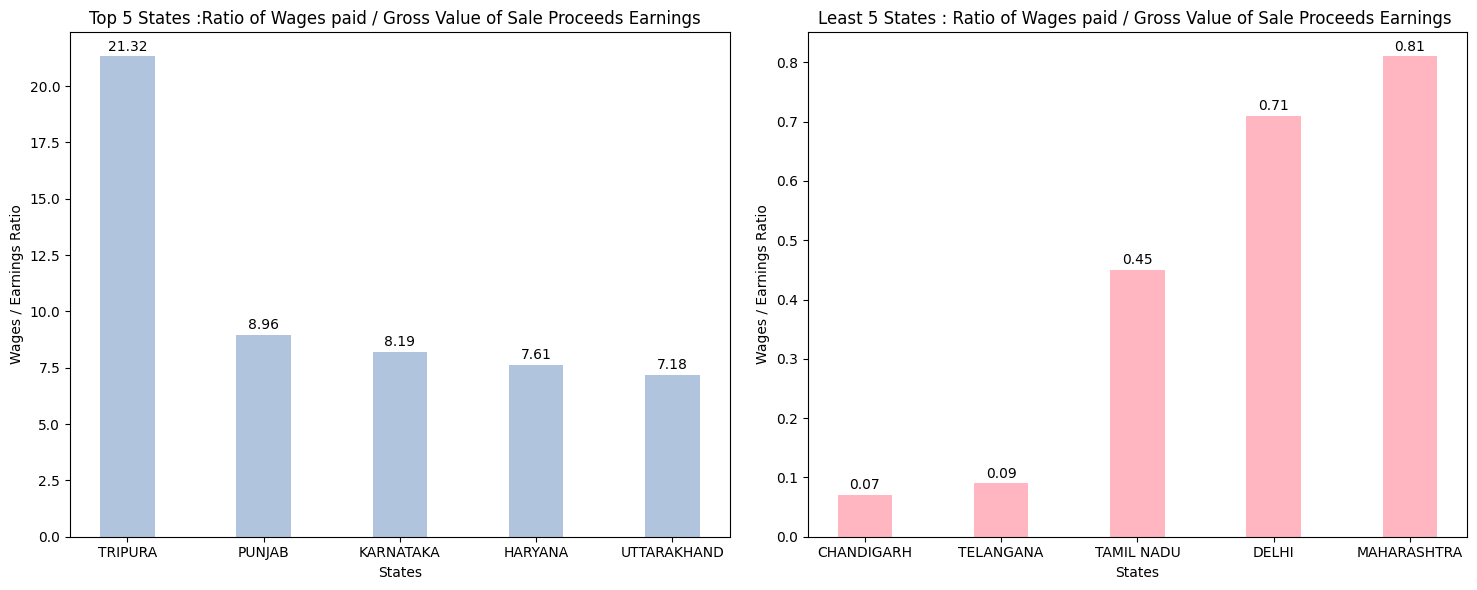

In [ ]:

Highest_1=Highest.toPandas()
Lowest_1=Lowest.toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))


plt.subplots_adjust(wspace=0.5)
graph1=ax1.bar(Highest_1['State/UT'],Highest_1['wages_Ratio'],color='LightSteelBlue',width=0.4)
ax1.set_xlabel('States')
ax1.set_ylabel("Wages / Earnings Ratio")
ax1.set_title("Top 5 States :Ratio of Wages paid / Gross Value of Sale Proceeds Earnings  ")
for bars in graph1:
    height = bars.get_height()
    ax1.annotate(f'{height:.2f}',
                 xy=(bars.get_x() + bars.get_width() / 2, height),
                 xytext=(0, 2),
                 textcoords="offset points",
                 ha='center', va='bottom')

graph2=ax2.bar(Lowest_1['State/UT'],Lowest_1['wages_Ratio'],color='LightPink',width=0.4)
ax2.set_xlabel('States')
ax2.set_ylabel("Wages / Earnings Ratio")
ax2.set_title("Least 5 States : Ratio of Wages paid / Gross Value of Sale Proceeds Earnings ")
for bars in graph2:
    height = bars.get_height()
    ax2.annotate(f'{height:.2f}',
                 xy=(bars.get_x() + bars.get_width() / 2, height),
                 xytext=(0, 2),
                 textcoords="offset points",
                 ha='center', va='bottom')


plt.tight_layout()
plt.show()